In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/medical-insurance-premium-prediction/Medicalpremium.csv


# Data Exploration

In [2]:
df = pd.read_csv('/kaggle/input/medical-insurance-premium-prediction/Medicalpremium.csv')
df.sample(4)

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
687,49,1,1,0,0,174,76,0,0,2,28000
173,47,1,0,1,0,168,83,0,0,1,38000
375,37,1,0,0,0,166,82,0,0,0,23000
836,29,1,0,0,0,145,62,0,0,0,15000


In [3]:
df.shape

(986, 11)

In [4]:
df.isnull().sum()

Age                        0
Diabetes                   0
BloodPressureProblems      0
AnyTransplants             0
AnyChronicDiseases         0
Height                     0
Weight                     0
KnownAllergies             0
HistoryOfCancerInFamily    0
NumberOfMajorSurgeries     0
PremiumPrice               0
dtype: int64

# Data Visualization

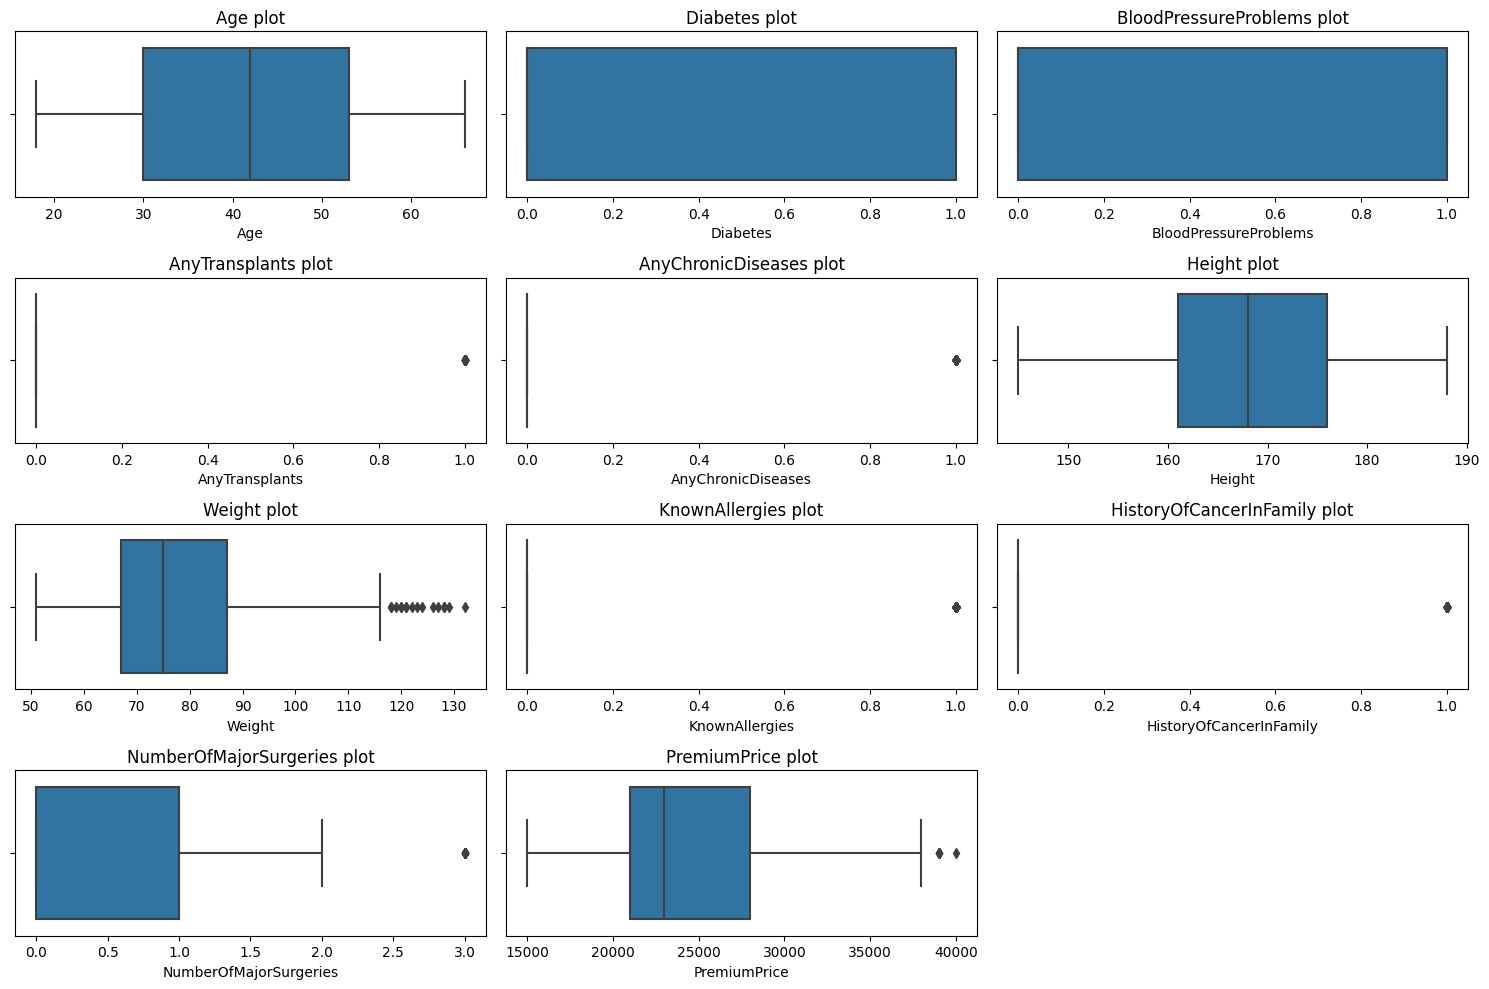

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Numerical Plots
def boxplot(num_cols):
    for i, j in enumerate(num_cols):
        plt.subplot(len(num_cols)//3+1, 3, i+1)
        sns.boxplot(data = df, x = j)
        plt.title(f"{j} plot")
        plt.tight_layout()

plt.figure(figsize = (15, 10))
boxplot(df.columns)

In [14]:
df.sample()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
472,47,0,1,0,0,170,77,0,0,1,23000


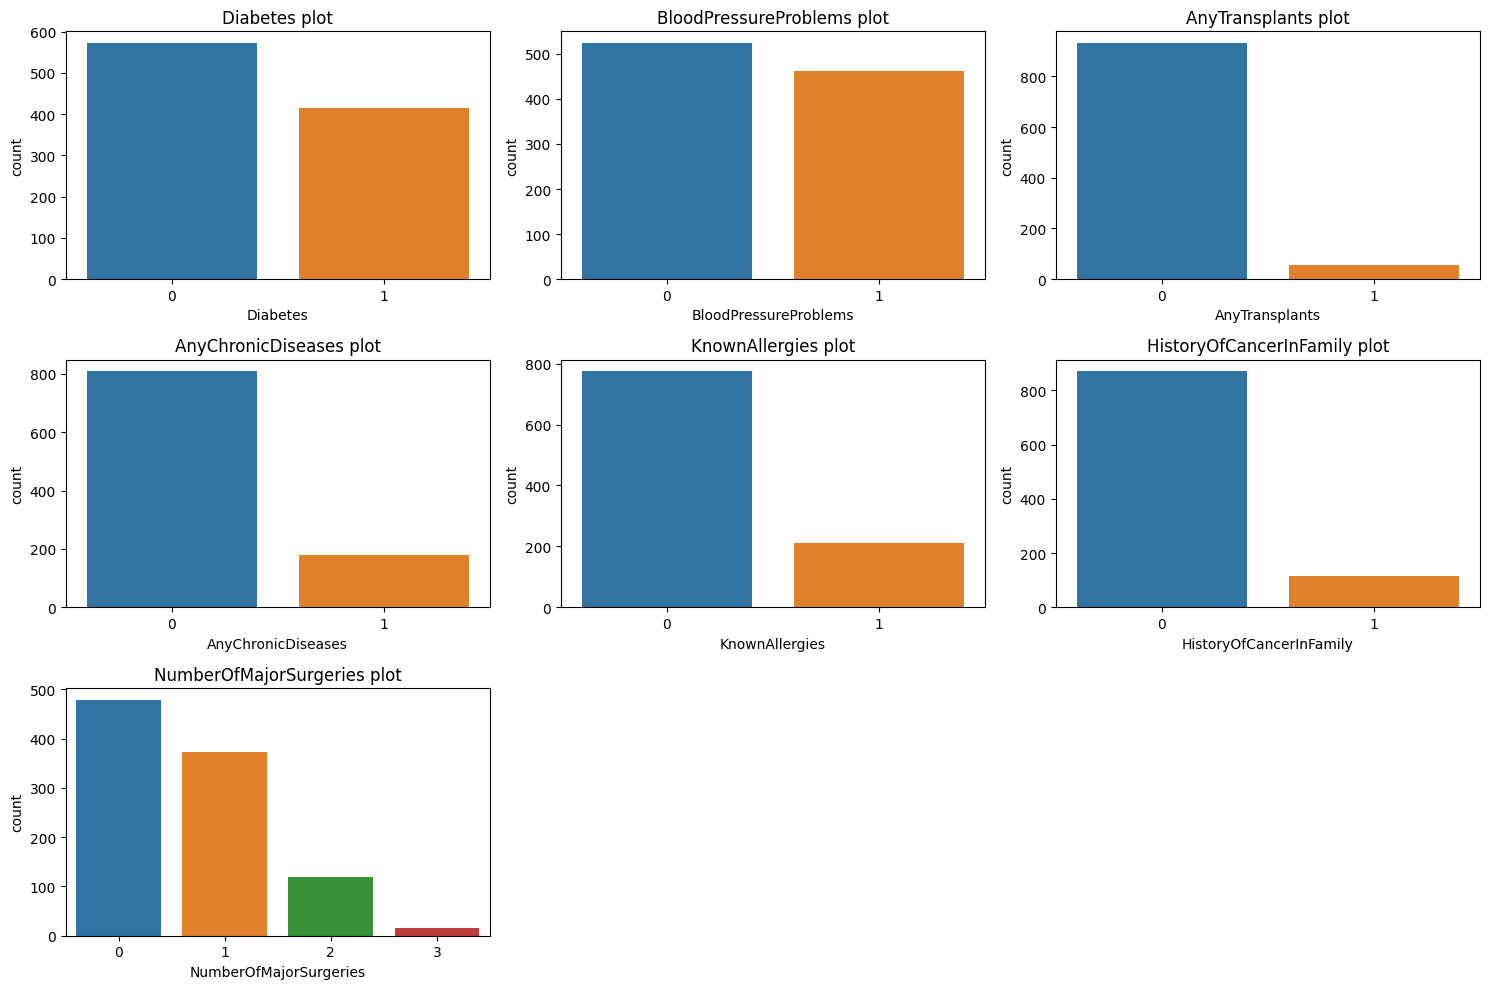

In [18]:
def countplot(num_cols):
    for i, j in enumerate(num_cols):
        plt.subplot(len(num_cols)//3+1, 3, i+1)
        sns.countplot(data = df, x = j)
        plt.title(f"{j} plot")
        plt.tight_layout()

plt.figure(figsize = (15, 10))
countplot(['Diabetes', 'BloodPressureProblems', 'AnyTransplants', 'AnyChronicDiseases', 'KnownAllergies', 'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries'])

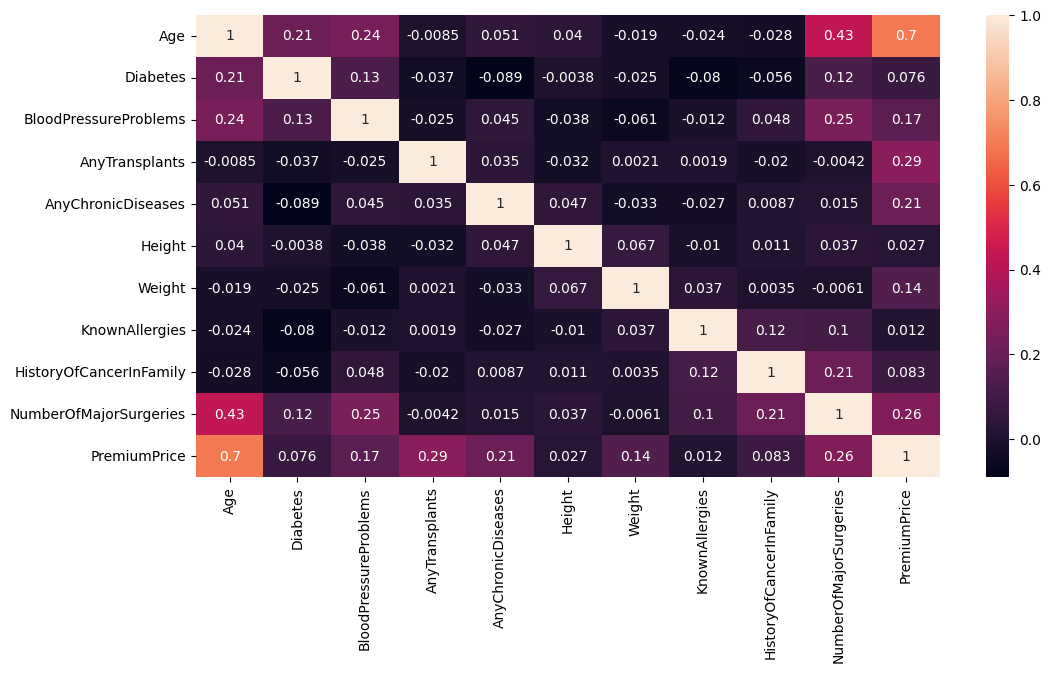

In [6]:
plt.figure(figsize = (12, 6))
sns.heatmap(df.corr(), annot = True)
plt.show()

**Insights**
- Premium pricing is primarily driven by age, followed by serious medical history factors such as past surgeries, chronic diseases, and organ transplants.
- Minor factors like height, weight, allergies, or family cancer history have minimal impact individually.
- These insights suggest that insurance companies rely heavily on age and major health events for risk-based pricing, while other features contribute less.

**Implication**: A predictive model for premiums should prioritize age and major medical conditions, while lower-impact features can still be included for incremental improvements.

# Train Test Split

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop('PremiumPrice', axis = 1)
y = df.PremiumPrice

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, train_size = 0.8)

scaler = StandardScaler()

num_cols = X_train.columns

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [8]:
X_train_scaled

array([[-1.61753552, -0.85771955, -0.92891558, ..., -0.52448156,
        -0.35908192, -0.87479875],
       [-0.76394905, -0.85771955,  1.07652409, ..., -0.52448156,
        -0.35908192, -0.87479875],
       [ 1.15662049,  1.16588226, -0.92891558, ..., -0.52448156,
        -0.35908192, -0.87479875],
       ...,
       [ 1.37001711,  1.16588226, -0.92891558, ..., -0.52448156,
        -0.35908192,  3.04934594],
       [-0.33715582,  1.16588226, -0.92891558, ...,  1.90664473,
         2.78487981,  0.43324948],
       [ 1.2277527 ,  1.16588226,  1.07652409, ..., -0.52448156,
         2.78487981,  0.43324948]])

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "Gradient Boost": GradientBoostingRegressor(),
    "XG Boost": XGBRegressor(),
    "KNN": KNeighborsRegressor()
}

result_list = []

for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rscore = r2_score(y_test, y_pred)

    metrics_dict = {
        "Model Name": model_name,
        "Mean Absolute Error": mae,
        "Mean Squared Error": mse,
        "Root Mean Sqaured Error": rmse,
        "R2 Score": rscore
    }

    result_list.append(metrics_dict)

metric_df = pd.DataFrame(result_list)
metric_df

,Model Name,Mean Absolute Error,Mean Squared Error,Root Mean Sqaured Error,R2 Score
0,Linear Regression,2586.225384,1.222166e+07,3495.949328,0.713394
1,Decision Tree,1166.666667,1.752020e+07,4185.714039,0.589140
2,Random Forest,1026.212121,5.198406e+06,2280.001218,0.878094
3,AdaBoost,3505.649635,1.985025e+07,4455.362079,0.534499
4,Gradient Boost,1500.888632,6.165395e+06,2483.021277,0.855418
5,XG Boost,1340.515196,8.582010e+06,2929.506829,0.798747
6,KNN,3024.242424,1.932646e+07,4396.187513,0.546782


In [10]:
metric_df['Mean Squared Error'] = round(metric_df['Mean Squared Error'],2)

In [11]:
metric_df.sort_values(['R2 Score', 'Mean Squared Error'], ascending = False)

,Model Name,Mean Absolute Error,Mean Squared Error,Root Mean Sqaured Error,R2 Score
2,Random Forest,1026.212121,5198405.56,2280.001218,0.878094
4,Gradient Boost,1500.888632,6165394.66,2483.021277,0.855418
5,XG Boost,1340.515196,8582010.26,2929.506829,0.798747
0,Linear Regression,2586.225384,12221661.71,3495.949328,0.713394
1,Decision Tree,1166.666667,17520202.02,4185.714039,0.589140
6,KNN,3024.242424,19326464.65,4396.187513,0.546782
3,AdaBoost,3505.649635,19850251.25,4455.362079,0.534499


**Key Observations**:

- Random Forest outperformed all other models with the lowest errors (MAE & RMSE) and the highest R² score of 0.888, indicating it explains ~89% of the variance in the target variable.
- Gradient Boosting also showed strong performance (R² = 0.855) but had slightly higher errors than Random Forest.
- XGBoost, although generally a strong algorithm, underperformed in this case (R² = 0.799). This may be due to dataset characteristics or the need for further hyperparameter tuning.
- Linear Regression captured some variance (R² = 0.713) but had relatively high errors, showing that simple linear assumptions were not sufficient.
- Decision Tree, AdaBoost, and KNN performed the worst, with high error rates and low explanatory power.

**Final Choice**:

Given its balance of high accuracy and generalization ability, Random Forest is selected as the final model for this project.

# Model Hyper-Parameter Tuning

In [12]:
from sklearn.model_selection import GridSearchCV, KFold

cv = KFold(7, shuffle = True)

rf_params = {
    'n_estimators': [100, 200],        
    'max_depth': [5, 7, 8],         
    'min_samples_split': [2, 5, 10],             
    'min_samples_leaf': [1, 2, 4],               
    'max_features': ['sqrt', 'log2'],    
    'criterion': ['squared_error', 'absolute_error']  
}

model = RandomForestRegressor()

gridcv = GridSearchCV(estimator = model, param_grid = rf_params, n_jobs = -1, scoring = 'r2')

gridcv.fit(X_train_scaled, y_train)
y_test_pred = gridcv.predict(X_test_scaled)


mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
rscore = r2_score(y_test, y_test_pred)

print("Mean Absolute Error: ", mae)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ", rmse)
print("R2 Score", rscore)

Mean Absolute Error:  1981.189076192643
Mean Squared Error:  7414896.990943273
Root Mean Squared Error:  2723.030846491327
R2 Score 0.8261160510113006
